In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import tensorflow as tf
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,LSTM,Bidirectional,Lambda,Conv1D
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sunspots/Sunspots.csv


In [3]:
df = pd.read_csv('/kaggle/input/sunspots/Sunspots.csv',index_col = 'Unnamed: 0')
df.columns

Index(['Date', 'Monthly Mean Total Sunspot Number'], dtype='object')

In [4]:
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [5]:
def input(df):
    x=[]
    y=[]
    step =0
    for i in np.arange(len(df)):
        x.append(step)
        y.append(float(df.iloc[i,1]))
        step+=1
    return x,y

In [6]:
time , temperature = input(df)

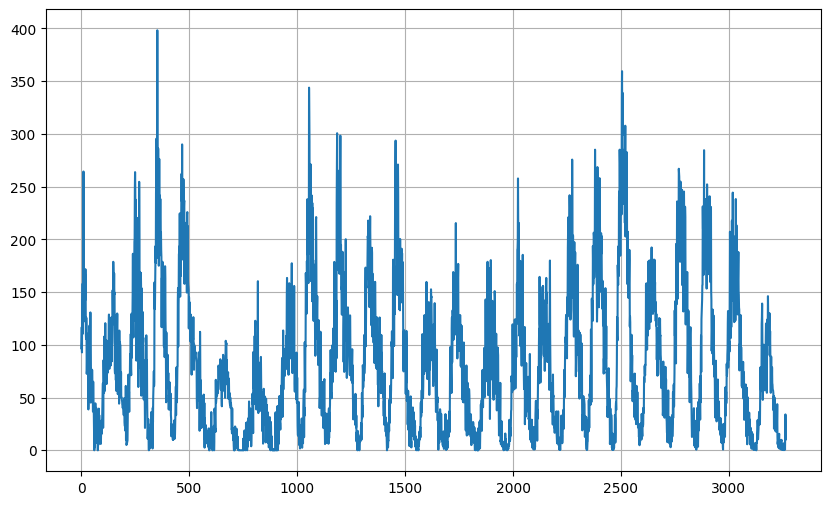

In [7]:
plt.figure(figsize = (10,6))
plt.plot(time,temperature)
plt.grid(True)

In [8]:
df['Monthly Mean Total Sunspot Number'].describe()

count    3265.000000
mean       81.778775
std        67.889277
min         0.000000
25%        23.900000
50%        67.200000
75%       122.500000
max       398.200000
Name: Monthly Mean Total Sunspot Number, dtype: float64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3265 entries, 0 to 3264
Data columns (total 2 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               3265 non-null   object 
 1   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1), object(1)
memory usage: 76.5+ KB


In [10]:
TIME_SPLIT = 2612

In [11]:
def train_val_split(time, series, time_step=TIME_SPLIT):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
x_train, y_train, x_test, y_test = train_val_split(time, temperature)

In [12]:
WINDOW_SIZE = 64
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [13]:
def windowed_dataset(y,window_size,batch_size,shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(y)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [14]:
train_set = windowed_dataset(y_train,WINDOW_SIZE,BATCH_SIZE,SHUFFLE_BUFFER_SIZE)
val_set = windowed_dataset(y_test,WINDOW_SIZE,BATCH_SIZE,SHUFFLE_BUFFER_SIZE)

In [15]:
def create_uncompiled_model():

    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv1D(filters = 32,kernel_size =5,padding = 'same',strides = 1,activation ='relu',input_shape = [None,1]),
        tf.keras.layers.LSTM(512,return_sequences =True),
        tf.keras.layers.LSTM(256,return_sequences =True),
        tf.keras.layers.LSTM(128,return_sequences =True),
        tf.keras.layers.LSTM(64,return_sequences =True),
        tf.keras.layers.LSTM(32,return_sequences =True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(50,activation ='relu'),
        tf.keras.layers.Dense(50,activation ='relu'),
        tf.keras.layers.Dense(30,activation ='relu'),
        tf.keras.layers.Dense(10,activation ='relu'),
        tf.keras.layers.Dense(1),
    ]) 


    return model

In [32]:
EarlyStop = keras.callbacks.EarlyStopping(monitor = 'val_mean_squared_error',patience = 3,restore_best_weights=True)

In [22]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
    model.compile(loss='mse',
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule,EarlyStop],validation_data =(val_set) )
    
    return history

In [23]:
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
80/80 [==============================] - 88s 926ms/step - loss: 10965.3154 - mae: 79.7799 - val_loss: 11473.6855 - val_mae: 80.6808 - lr: 1.0000e-04
Epoch 2/100
80/80 [==============================] - 71s 892ms/step - loss: 10565.8750 - mae: 77.5009 - val_loss: 10763.8848 - val_mae: 76.6770 - lr: 1.1220e-04
Epoch 3/100
80/80 [==============================] - 70s 875ms/step - loss: 9346.9629 - mae: 70.7463 - val_loss: 8836.3682 - val_mae: 67.1637 - lr: 1.2589e-04
Epoch 4/100
80/80 [==============================] - 72s 900ms/step - loss: 6765.7871 - mae: 59.2524 - val_loss: 5794.5723 - val_mae: 57.7639 - lr: 1.4125e-04
Epoch 5/100
80/80 [==============================] - 71s 892ms/step - loss: 4756.5083 - mae: 53.3421 - val_loss: 4971.3682 - val_mae: 58.9793 - lr: 1.5849e-04
Epoch 6/100
80/80 [==============================] - 72s 901ms/step - loss: 4603.9673 - mae: 54.3233 - val_loss: 4418.8716 - val_mae: 53.4854 - lr: 1.7783e-04
Epoch 7/100
80/80 [=======================

In [24]:
loss =pd.DataFrame(data = lr_history.history)

In [25]:
loss

,loss,mae,val_loss,val_mae,lr
0,10965.315430,79.779877,11473.685547,80.680794,0.000100
1,10565.875000,77.500854,10763.884766,76.676971,0.000112
2,9346.962891,70.746323,8836.368164,67.163734,0.000126
3,6765.787109,59.252430,5794.572266,57.763874,0.000141
4,4756.508301,53.342133,4971.368164,58.979263,0.000158
5,4603.967285,54.323273,4418.871582,53.485435,0.000178
6,2197.265381,31.453316,1039.740112,23.210787,0.000200
7,1061.603271,23.126425,541.053223,17.413338,0.000224
8,800.616516,20.337301,661.345459,18.009617,0.000251
9,735.975342,19.735519,569.368652,17.071144,0.000282


(0.0001, 10.0, 0.0, 1000.0)

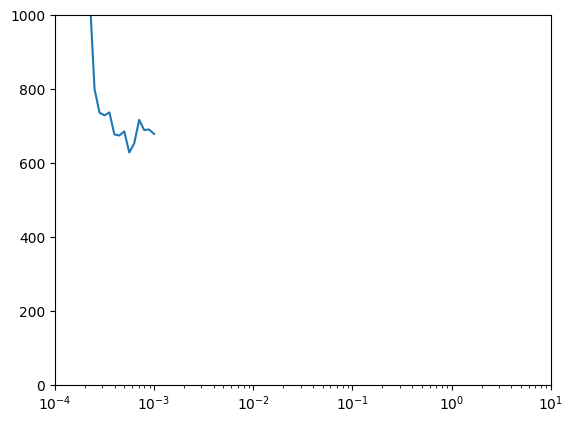

In [30]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 1000])

(0.0001, 10.0, 0.0, 700.0)

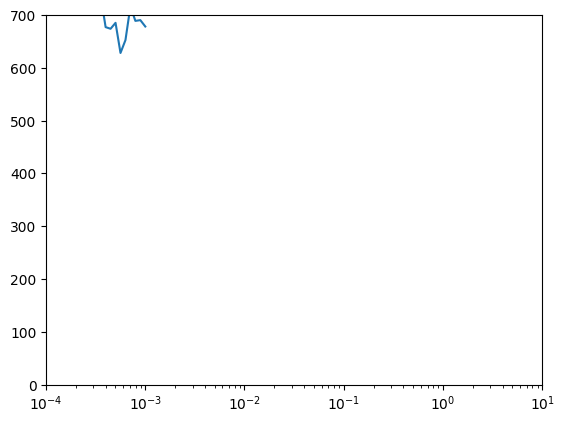

In [28]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 700])

In [31]:
def create_model():

    
    model = create_uncompiled_model()
    model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0006),
                  metrics=["mae"])  

    return model

In [35]:
model = create_model()
history = model.fit(train_set, epochs=100)

Epoch 1/100
80/80 [==============================] - 89s 936ms/step - loss: 9728.1064 - mae: 73.2890
Epoch 2/100
80/80 [==============================] - 75s 934ms/step - loss: 4875.3052 - mae: 54.4429
Epoch 3/100
80/80 [==============================] - 74s 924ms/step - loss: 4615.1196 - mae: 54.4934
Epoch 4/100
80/80 [==============================] - 75s 930ms/step - loss: 4618.7529 - mae: 54.4847
Epoch 5/100
80/80 [==============================] - 75s 940ms/step - loss: 4610.7168 - mae: 54.4828
Epoch 6/100
80/80 [==============================] - 78s 975ms/step - loss: 3039.7224 - mae: 40.5940
Epoch 7/100
80/80 [==============================] - 74s 924ms/step - loss: 920.5961 - mae: 22.1318
Epoch 8/100
80/80 [==============================] - 76s 949ms/step - loss: 765.3918 - mae: 20.1336
Epoch 9/100
80/80 [==============================] - 76s 944ms/step - loss: 687.4570 - mae: 18.8377
Epoch 10/100
80/80 [==============================] - 75s 937ms/step - loss: 687.9707 - mae: 1

In [39]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae


In [53]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [54]:
rnn_forecast = model_forecast(model, temperature, WINDOW_SIZE).squeeze()

101/101 [==============================] - 27s 243ms/step


In [55]:
rnn_forecast = rnn_forecast[TIME_SPLIT - WINDOW_SIZE:-1]


In [56]:
len(rnn_forecast)

653

In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, rnn_forecast)
mse = mean_squared_error(y_test, rnn_forecast)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Error (MSE): {mse:.2f}")

Mean Absolute Error (MAE): 19.99
Mean Absolute Error (MSE): 744.47


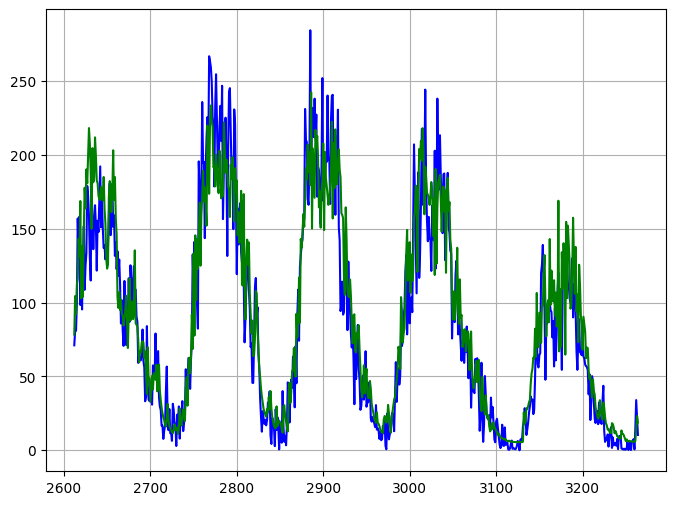

In [67]:
plt.figure(figsize=(8, 6))
plt.plot(x_test, y_test,c = 'b')
plt.plot(x_test, rnn_forecast,c = 'g')
plt.grid(True)